### Basic imports

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm import tqdm_notebook as tqdm

In [2]:
pd.set_option('display.max_colwidth', 100)

### Definitions

#### Get size of variables in memory

In [3]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def get_size_of_vars(n=10):
    size_of_rest = 0
    i = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                             key= lambda x: -x[1]):
        if i < n:
            print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
        else:
            size_of_rest += size
        i += 1

    print("{:>30}: {:>8}".format('Size of rest', sizeof_fmt(size_of_rest)))

#### Get topic mixtures, print topic examples

In [4]:
def get_hsbm_topics_dict(hsbm_model, level=0, num_words=100):
    topics = hsbm_model.topics(l=level,n=num_words)
    freq_sum = {topic : sum([freq for (word, freq) in word_freq]) 
                for (topic, word_freq) in topics.items() }
    return {topic : {word : freq/freq_sum[topic] for (word, freq) in word_freq} 
                for (topic, word_freq) in topics.items() }

def get_lda_topics_dict(lda_model, num_topics=-1, num_words=100):
    topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
    freq_sum = {topic : sum([freq for (word, freq) in word_freq]) 
                for (topic, word_freq) in topics }
    return {topic : {word : freq/freq_sum[topic] for (word, freq) in word_freq} 
                for (topic, word_freq) in topics}

def get_topic_score(token_list, topics_dict):
    return [sum([topics_dict[topic].get(t, 0) for t in token_list]) / len(token_list)
            for topic in topics_dict]

def get_mixture_custom(doc_list, topics_dict):
    doc_scores = data.loc[doc_list].tokens.apply(get_topic_score, args=(topics_dict,))
    return pd.DataFrame(index=doc_scores.index,
                        columns=topics_dict.keys(), 
                        data=np.stack(doc_scores.values) / (np.stack(doc_scores.values).sum(axis=1).reshape(-1,1) + np.finfo(float).eps)
                       )

def get_mixture_hsbm(doc_list, hsbm_model, level=2):
    doc2id = {doc : i for (i, doc) in enumerate(hsbm_model.documents)}
    return pd.DataFrame(index=doc_list, 
                        columns=hsbm_model.topics(l=level).keys(),
                        data=[[ratio for topic, ratio in topic_dist] 
                              for topic_dist in map(lambda doc: hsbm_model.topicdist(doc2id[str(doc)], l=level), doc_list)]
                         )

def get_mixture_lda(doc_list, lda_model, bow_corpus):
    return pd.DataFrame(index=doc_list, 
                        columns=range(lda_model.get_topics().shape[0]),
                        data=[{topic:ratio for topic, ratio in topic_dist} 
                              for topic_dist in map(lambda doc: lda_model.get_document_topics(bow_corpus[doc]), doc_list)]
                         )
    
def print_topic_examples(mixture_df, n_examples=5):

    for topic in mixture_df.columns: 
        print('-'*100)
        print('-'*40 + f' TOPIC: {topic} ' + '-'*40)
        print('-'*100 + '\n\n')

        top_score_ids = mixture_df.sort_values(by=topic, ascending=False).iloc[:n_examples, topic].index
        for text in data.text[top_score_ids]:
            print(text)
            print('-'*100 + '\n')

## Read data

In [5]:
import ast

In [6]:
dir_path = '../data/tweets_maga/'
data_original = pd.read_csv(dir_path + 'data_merged.csv', index_col=0)
# convert tokens column from string to list
data_original['tokens'] = data_original.tokens.apply(lambda l: ast.literal_eval(l))
data_original

,author_name,created_at,id,text,tokens
0,RealPatriot,2019-10-01 00:37:21,1178831229963116544,@realDonaldTrump I’m confused. Is this a new “greatest” or the same as the old? All of your scan...,"[confus, new, greatest, old, scandal, hard, follow, pussygrabb]"
1,Teresa murray⭐⭐⭐ CIA #fakewistleblower 😡,2019-10-01 00:37:20,1178831224191832067,"@realDonaldTrump @Hyundai @Kia @Aptiv I'm not yet tired of winning, Sir! #MAGA","[yet, tire, win, sir]"
2,GOPKnowsBest,2019-10-01 00:37:17,1178831213571629057,@WA_Silenced_Maj @realDonaldTrump You are the true patriots! If Antifa physically assaults you ...,"[true, patriot, antifa, physic, assault, way, legal, defend]"
3,Peter Dunbar,2019-10-01 00:37:15,1178831204151226368,It is amazing to watch @RudyGiuliani throw his reputation down the toilet. My guess @realDonaldT...,"[amaz, watch, throw, reput, toilet, guess, someth, mayb, bumbl, old, fool, hard, tell]"
4,AtlanticCity Deplorable,2019-10-01 00:37:04,1178831160635514880,@w_terrence @realDonaldTrump WHOOOOOHOOOOO! I’m so excited for you! #MAGA #KAG2020♥️🇺🇸,"[whooohooo, excit]"
5,Michael O'Grady,2019-10-01 00:36:58,1178831134156820480,#Trump LIED ABOUT WIKILEAKS in #MuellerReport\n\nThe grand-jury REDACTIONS in special counsel #M...,"[lie, wikileak, grand, juri, redact, special, counsel, report, show, presid, trump, lie, knowled..."
6,Lynn McCracken,2019-10-01 00:36:43,1178831070067924992,Never polled and don't know anyone that has. \n#MAGA https://t.co/n1bzaxntWX,"[never, poll, know, anyon]"
7,U R Busted,2019-10-01 00:36:41,1178831062304202754,#GettumGirl\n\n#Maga needs to get off their ass and put their foot down!\n\nDems/Antifa (same th...,"[need, get, ass, put, foot, dem, antifa, thing, cross, line]"
8,McQ,2019-10-01 00:36:39,1178831051881418757,@realDonaldTrump Beautiful!\n#KAG\n#MAGA,[beauti]
9,SJ 🌟🌟🌟,2019-10-01 00:36:27,1178831004485636096,#RedOctober Did #Q mean this October? \nMaybe #JuanOSavin is onto something regarding this horri...,"[mean, octob, mayb, onto, someth, regard, horribl, excus]"


## Post cleaning

In [7]:
import gensim

In [8]:
data = deepcopy(data_original)

t_dict = gensim.corpora.Dictionary(data.tokens)
print('Initial unique tokens:', len(t_dict.keys()))

# drop tokens occuring in less than <no_below> tweets
# drop tokens occuring in more than <no_above> portion of the data
# keep only the <keep_n> most frequent tokens
t_dict.filter_extremes(no_below=20, no_above=0.5, keep_n=100000)
remaining_tokens = set(t_dict.token2id.keys())
data['tokens'] = data.tokens.apply(lambda tokens: [t for t in tokens if t in remaining_tokens])

print('Remaining unique tokens:', len(remaining_tokens))

Initial unique tokens: 19260
Remaining unique tokens: 2708


In [9]:
# drop tweets with <= 1 words left
data.drop(index=data[data.tokens.str.len() <= 1].index, inplace=True)

print('Original / remaining #tweets:')
print(len(data_original), '/', len(data))

Original / remaining #tweets:
44812 / 43160


## Network based approach

### Build network

In [10]:
import networkx as nx
from networkx.algorithms.community import *
import graph_tool as gt
from sbmtm import sbmtm
import itertools

#### Naive (word-word)

In [196]:
G = nx.Graph()

for token_list in tqdm(data.tokens):
    
    for edge in itertools.combinations(token_list, 2):
        w = G.get_edge_data(*edge, default={'weight':0})['weight'] + 1
        G.add_edge(*edge, weight=w)

G = nx.convert_node_labels_to_integers(G, label_attribute='label')
print(nx.info(G))
deg_med = np.median([deg for node, deg in G.degree(weight='weight')])
print(f'Median degree: {deg_med}')


Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 757736
Average degree: 559.6278
Median degree: 679.5


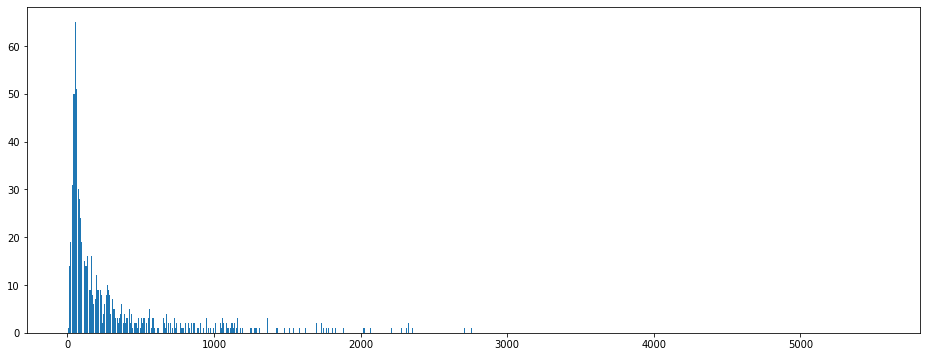

In [17]:
hist = nx.degree_histogram(G)

plt.figure(figsize=(16,6))
plt.bar(range(len(hist)), hist)

plt.show()

#### Proper (word-tweet)

In [11]:
filters = (data.tokens.str.len() >= 15)
print(f'Number of tweets: {len(data[filters])}')
print(f'Number of tokens: {data[filters].tokens.str.len().sum()}')

Number of tweets: 9180
Number of tokens: 171465


In [12]:
data[filters].tokens.str.len().sum()

171465

In [13]:
from sbmtm import sbmtm
import graph_tool.all as gt

texts = list(data[filters].tokens)
titles = list(data[filters].index)

## we create an instance of the sbmtm-class
hsbm_model = sbmtm()

## we have to create the word-document network from the corpus
hsbm_model.make_graph(texts,documents=titles)

## we can also skip the previous step by saving/loading a graph
hsbm_model.save_graph(filename = dir_path + 'tmp.xml.gz')
# model.load_graph(filename = dir_path + 'tmp.xml.gz')

### Find communities

#### hSBM (hierarchical Stochastic Bolc Model)

In [14]:
## fit the model
gt.seed_rng(42)
hsbm_model.fit()

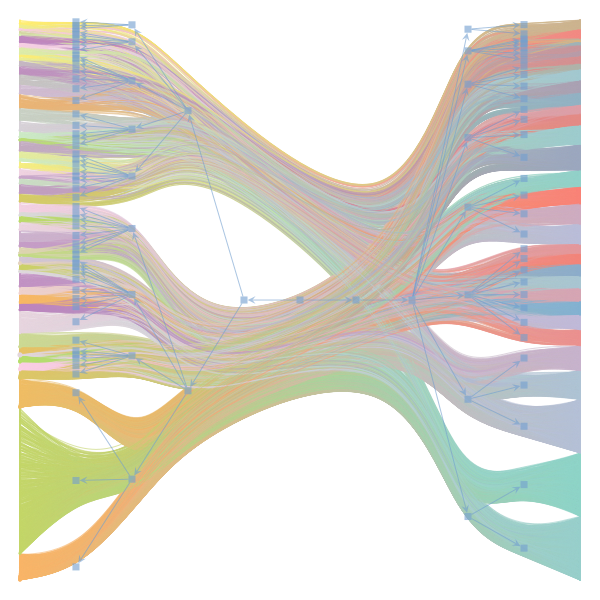

In [15]:
hsbm_model.plot(nedges=10000)

In [29]:
level=1
hsbm_model.topics(l=level, n=10)

{0: [('white', 0.03293542355817633),
  ('illeg', 0.02962749892132892),
  ('hat', 0.026751042715374658),
  ('bill', 0.021141953113763844),
  ('red', 0.018696965338702718),
  ('freedom', 0.017546382856321013),
  ('citi', 0.017114914425427872),
  ('border', 0.016683445994534734),
  ('black', 0.016251977563641593),
  ('ralli', 0.015676686322450742)],
 1: [('get', 0.02971292166593379),
  ('make', 0.020143643863726784),
  ('one', 0.01658395627866072),
  ('want', 0.016416441568775256),
  ('support', 0.015536989341876584),
  ('go', 0.014552840421299496),
  ('need', 0.014322507695206986),
  ('take', 0.014154992985321524),
  ('see', 0.013945599597964696),
  ('right', 0.01266829993508805)],
 2: [('amp', 0.07740464344941957),
  ('america', 0.03221393034825871),
  ('great', 0.020771144278606966),
  ('thank', 0.019402985074626865),
  ('love', 0.016127694859038144),
  ('fight', 0.015091210613598673),
  ('show', 0.014800995024875621),
  ('pay', 0.013101160862354893),
  ('offic', 0.01214759535655058),


In [18]:
hsbm_mixture_df = get_mixture_hsbm(data[filters].index, hsbm_model, level=level)
print(hsbm_mixture_df.idxmax(axis=1).value_counts())
print(hsbm_mixture_df.sum(axis=0).sort_values(ascending=False))


1    5145
3    1825
2     935
5     440
4     428
0     194
6     137
7      72
8       4
dtype: int64
1    2777.548331
3    2059.176679
2    1398.167339
5    1017.671781
4     627.074383
6     511.695482
0     403.553654
7     260.654878
8     124.457474
dtype: float64


In [20]:
print_topic_examples(get_mixture_hsbm(data[filters].index, hsbm_model, level=level), n_examples=10)

----------------------------------------------------------------------------------------------------
---------------------------------------- TOPIC: 0 ----------------------------------------
----------------------------------------------------------------------------------------------------


Rashida Tlaib, in contentious tour, tells Detroit police chief to hire only black analysts for facial recognition program | Fox News - 

#MAGA #KAG #TRUMP2020 #TRUMP #PATRIOT #CONSERVATIVE #NRA
#SchiffLied #SchiffForBrains #FakeWhistleblower

https://t.co/5SFAt0ylch on @foxnews
----------------------------------------------------------------------------------------------------

California Charity Event for Fallen Police Officer Canceled by Local Police Chief After Learning Scott Baio and Joy Villa Were Speaking (VIDEO) https://t.co/19DF2Ljdxf #UniteBlue #MAGA
----------------------------------------------------------------------------------------------------

@RepRashida @RashidaTlaib 

You are a

#### Greedy modularity

In [45]:
comms = list(greedy_modularity_communities(G))

In [46]:
comms

[frozenset({32768,
            1,
            3,
            32771,
            7,
            32775,
            9,
            11,
            32780,
            14,
            32782,
            16,
            'podesta',
            19,
            32787,
            32789,
            22,
            24,
            32793,
            26,
            32795,
            29,
            32797,
            32801,
            34,
            35,
            36,
            32809,
            'fill',
            32814,
            47,
            32816,
            'jeer',
            50,
            51,
            32817,
            54,
            59,
            32827,
            32828,
            62,
            32830,
            32831,
            'diaper',
            72,
            32842,
            'classi',
            'nit',
            32846,
            32848,
            'theyd',
            82,
            83,
            32850,
            86,
            32856,
 

#### Girwan-Newman

In [113]:
comms_gn = girvan_newman(G)

In [114]:
k = 5
comms_limited = itertools.takewhile(lambda c: len(c) <= k, comms_gn)
for communities in comms_limited:
    print(tuple(sorted(c) for c in communities))

KeyboardInterrupt: 

#### K-Clique

In [ ]:
k = 4
c = list(k_clique_communities(G, k))
c

## LDA (Latent Dirichlet Allocation)

In [21]:
print(f'Number of tweets: {len(data[filters])}')
print(f'Number of words: {data[filters].tokens.str.len().sum()}')

Number of tweets: 9180
Number of words: 171465


In [22]:
bow_corpus = data[filters].tokens.apply(t_dict.doc2bow)

In [23]:
lda_models = {}

lda_models[1] = gensim.models.LdaMulticore(
    corpus=bow_corpus,
    num_topics=len(hsbm_model.topics(l=1)),
    passes=5,
    id2word=t_dict,
    workers=3
)

lda_models[2] = gensim.models.LdaMulticore(
    corpus=bow_corpus,
    num_topics=len(hsbm_model.topics(l=2)),
    passes=5,
    id2word=t_dict,
    workers=3
)

In [30]:
level=1
lda_models[level].show_topics(num_topics=-1, num_words=15, formatted=False)

[(0,
  [('amp', 0.026617082),
   ('american', 0.015546395),
   ('make', 0.01389711),
   ('america', 0.011506456),
   ('vote', 0.009091699),
   ('time', 0.008595626),
   ('presid', 0.007815123),
   ('peopl', 0.0073405267),
   ('take', 0.0073184334),
   ('think', 0.006973385),
   ('work', 0.006955224),
   ('get', 0.006571588),
   ('need', 0.006337825),
   ('countri', 0.006195122),
   ('elect', 0.006185637)]),
 (1,
  [('peopl', 0.018687395),
   ('get', 0.015119137),
   ('say', 0.011494717),
   ('amp', 0.011184615),
   ('presid', 0.00807513),
   ('would', 0.0076167616),
   ('know', 0.0073893177),
   ('trump', 0.0072978465),
   ('time', 0.006681996),
   ('mani', 0.0066019716),
   ('countri', 0.006485623),
   ('take', 0.0064694155),
   ('see', 0.006405537),
   ('american', 0.006133212),
   ('tell', 0.0060457843)]),
 (2,
  [('trump', 0.04446975),
   ('presid', 0.019702649),
   ('say', 0.012274449),
   ('lie', 0.01088878),
   ('impeach', 0.008978469),
   ('support', 0.0081662545),
   ('amp', 0

In [25]:
lda_mixture_df = get_mixture_lda(data[filters].index, lda_models[level], bow_corpus)
print(lda_mixture_df.idxmax(axis=1).value_counts())
print(lda_mixture_df.sum(axis=0).sort_values(ascending=False))

5    1339
2    1248
0    1237
7    1185
1    1038
6     931
8     871
3     744
4     587
dtype: int64
5    1218.575476
2    1170.155390
0    1157.746977
7    1125.552999
1     993.355303
6     924.906607
8     829.832007
3     735.041817
4     649.780399
dtype: float64


In [26]:
print_topic_examples(lda_mixture_df, n_examples=10)

----------------------------------------------------------------------------------------------------
---------------------------------------- TOPIC: 0 ----------------------------------------
----------------------------------------------------------------------------------------------------


@DanaPerino Only thing more tiring than @TheDemocrats never ending coup attempt is never ending election cycle. Before votes counted politicians on to the next election. Democrats constantly beating drums hurting Nation. Seems coup attempt &amp; election cycle one in the same! #MAGA
----------------------------------------------------------------------------------------------------

@titoortiz well done sir. I love the respect u show to @realDonaldTrump , which our Commander in Chief deserves. Even if people don’t agree politically, he should still be respected, IMO. Definitely good to see &amp; screw the HATERS. Anyways, be good bro, &amp; remember #MAGA #KAG2020 https://t.co/PUEtCLLqxJ
--------

## Results, comparison

In [61]:
print_topic_examples(get_mixture_hsbm(data[filters].index, hsbm_model, level=2))

----------------------------------------------------------------------------------------------------
---------------------------------------- TOPIC: 0 ----------------------------------------
----------------------------------------------------------------------------------------------------


So many serious #brexit topics, without anyone (I've found) covering the most important of all #football. Not even @GaryLineker.

Let's get the ball rolling. 10 things you did or even didn't know about how #BrexitShambles affects the game. We was robbed!

https://t.co/5RQ69PFEi4
----------------------------------------------------------------------------------------------------

Can't support this statement enough, #climate, #housing, borders, #brexit, #inequality inequality and the #environment are some the biggest issues facing Ireland today and a good geography education is vital for understanding them @geogsocire @JohnHalligan https://t.co/NYDXMcrBBi
------------------------------------------

In [62]:
print_topic_examples(get_mixture_lda(data[filters].index, lda_models[2], bow_corpus))

----------------------------------------------------------------------------------------------------
---------------------------------------- TOPIC: 0 ----------------------------------------
----------------------------------------------------------------------------------------------------


@GaryLineker Cheering to end FoM, to have less rights, less protection, higher prices, higher taxes, lower standards for food &amp; medicine, a weaker currency, an isolated island controlled by Etonian liars... That's Brexit for you.

If only Brexiteers would open their eyes &amp; see it. #Brexit
----------------------------------------------------------------------------------------------------

@BBCPolitics Cheering to end FoM, to have less rights, less protection, higher prices, higher taxes, lower standards for food &amp; medicine, a weaker currency, an isolated island controlled by Etonian liars... That's Brexit for you.

If only Brexiteers would open their eyes &amp; see it. #Brexit
-------

In [215]:
print_topic_examples(get_mixture_custom())

----------------------------------------------------------------------------------------------------
---------------------------------------- TOPIC: 0 ----------------------------------------
----------------------------------------------------------------------------------------------------


Trump Trump 2016.@realDonaldTrump Trump @2020 trump  Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump #MAGA
----------------------------------------------------------------------------------------------------

@ChatByCC @realDonaldTrump @BreitbartNews Me too

I stand with President Trump!

I stand with President Trump!

I stand with President Trump!

I stand with President Trump!

I stand with President Trump!

I stand with President Trump!

I stand with President Trump!

I stand with President Trump!
🇺🇸🇺🇸⚖️🗽🇺🇸🇺🇸
#KAG #MAGA
--------------------------